<a href="https://colab.research.google.com/github/EvgenyEsin/A-B_test/blob/main/A_B_test_DZ_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ДЗ к семинару 9

Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

Mobile Games AB Testing with Cookie Cats

In [1]:
# Загрузка библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy import stats
from scipy.stats import shapiro

import statsmodels as sm
from statsmodels.stats.power import TTestIndPower

import statsmodels.stats.api as sms
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, pearsonr, spearmanr, \
    kendalltau, f_oneway, kruskal

from os import replace

In [2]:
# Чтение файла
df = pd.read_csv('результаты А_B - cookie_cats 2.csv')
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
...,...,...,...,...,...
90184,9999441,gate_40,97,1,0
90185,9999479,gate_40,30,0,0
90186,9999710,gate_30,28,1,0
90187,9999768,gate_40,51,1,0


## Анализ и предобработка данных

Выведем статистику

In [3]:
df.shape

(90189, 5)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


In [5]:
df.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189.000000,90189.000000,90189.000000
mean,4.998412e+06,51.872457,0.445210,0.186065
std,2.883286e+06,195.050858,0.496992,0.389161
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512230e+06,5.000000,0.000000,0.000000
50%,4.995815e+06,16.000000,0.000000,0.000000
75%,7.496452e+06,51.000000,1.000000,0.000000
max,9.999861e+06,49854.000000,1.000000,1.000000


In [6]:
# Проверка на пустые строки
df.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

Датасет состоит из 90189 строк и 5 столбцов: userid, version (версия), sum_gamerounds (сумма игровых раундов), retention_1 (удержание в течение 1 дня после установки) и retention_7 (7 дней).

Значения в столбцах различаются по типу переменных: int64 и object.

Отрицательных значений нет.

Рассмортим отдельно каждый столбец.

### userid

In [7]:
# провепим на дубликаты
doubble = df['userid'].duplicated().sum()
print(f'Дубликатов: {doubble}')

Дубликатов: 0


### version

Был ли игрок поставлен в контрольную группу (gate_30 - ворота 30 уровня) или в группу с перемещенными воротами (gate_40 - ворота 40 уровня).

gate_40    45489
gate_30    44700
Name: version, dtype: int64

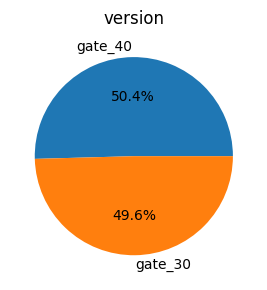

In [8]:
# Обратимся к следующему столбцу с символьными значениями. Выведем в виде таблицы и круговой диаграммы все значения и их количество
df.version.value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(3,3))
plt.title('version')
plt.tight_layout()
plt.axis('off');
df.version.value_counts()

Как видим, в этом столбце всего два варианта значений, количество которых примерно равны между собой.

Выведем статистику отдельно по двум группам пользователей

In [9]:
df[df['version']=='gate_40'].describe() # группа gate_40

,userid,sum_gamerounds,retention_1,retention_7
count,4.548900e+04,45489.000000,45489.000000,45489.000000
mean,5.009073e+06,51.298776,0.442283,0.182000
std,2.885496e+06,103.294416,0.496663,0.385849
min,3.770000e+02,0.000000,0.000000,0.000000
25%,2.517171e+06,5.000000,0.000000,0.000000
50%,5.007329e+06,16.000000,0.000000,0.000000
75%,7.510762e+06,52.000000,1.000000,0.000000
max,9.999861e+06,2640.000000,1.000000,1.000000


In [10]:
df[df['version']=='gate_30'].describe() # группа gate_30

,userid,sum_gamerounds,retention_1,retention_7
count,4.470000e+04,44700.000000,44700.000000,44700.000000
mean,4.987564e+06,52.456264,0.448188,0.190201
std,2.881026e+06,256.716423,0.497314,0.392464
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.505469e+06,5.000000,0.000000,0.000000
50%,4.983631e+06,17.000000,0.000000,0.000000
75%,7.481497e+06,50.000000,1.000000,0.000000
max,9.999710e+06,49854.000000,1.000000,1.000000


По предварительному анализу делаем вывод о том, что в группе gate_30 показатели лучше: тут выше среднее и максимальное значение.

### sum_gamerounds

In [11]:
# здесь указано суммарное время игрового раунда пользователей
df.sum_gamerounds.describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

Уже можно заметить, что все перцентили низкие, а значение max очень высокое (49854). Эти призники говорят о возможных выбросах больших значений.

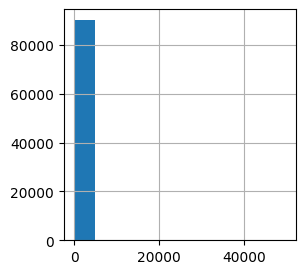

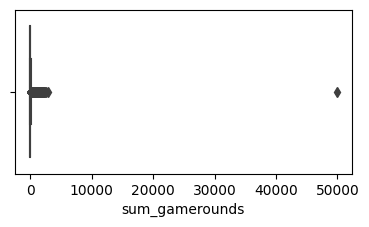

In [12]:
# посмотрим на график распрадалания значений этого столбца.
df['sum_gamerounds'].hist(figsize=(3, 3));
plt.figure(figsize = (20,20))
for i,col in enumerate(['sum_gamerounds']):
    plt.subplot(8,4,i+1)
    sns.boxplot(x = col, data = df)
plt.show()

Мы видим единичный выброс 49854.

In [13]:
# Удалим выброс
df = df.loc[df['sum_gamerounds']<49854]
df.shape

(90188, 5)

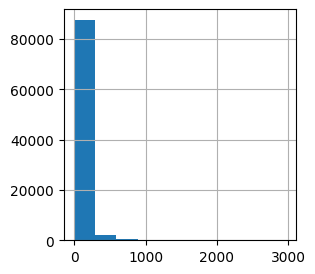

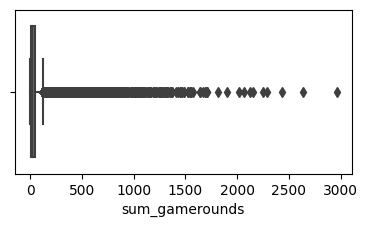

In [14]:
# посмотрим на график распрадалания значений этого столбца без выброса.
df['sum_gamerounds'].hist(figsize=(3, 3));
plt.figure(figsize = (20,20))
for i,col in enumerate(['sum_gamerounds']):
    plt.subplot(8,4,i+1)
    sns.boxplot(x = col, data = df)
plt.show()

In [15]:
df.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,9.018800e+04,90188.000000,90188.000000,90188.000000
mean,4.998397e+06,51.320253,0.445214,0.186056
std,2.883298e+06,102.682719,0.496992,0.389154
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512211e+06,5.000000,0.000000,0.000000
50%,4.995804e+06,16.000000,0.000000,0.000000
75%,7.496461e+06,51.000000,1.000000,0.000000
max,9.999861e+06,2961.000000,1.000000,1.000000


### retention_1

In [16]:
# Игрок вернулся через 1 день после установки?
df.retention_1.value_counts()

0    50035
1    40153
Name: retention_1, dtype: int64

### retention_7

In [17]:
# Игрок вернулся через 7 дней после установки?
df.retention_7.value_counts()

0    73408
1    16780
Name: retention_7, dtype: int64

До 7 дней играли только 16780 игроков

In [18]:
df_gate_30 = df['sum_gamerounds'][df['version']=='gate_30'] # тестовая половина
df_gate_40 = df['sum_gamerounds'][df['version']!='gate_30'] # контрольная половина

### Вывод по анализу датасета.
В датасете содержатся сведения о пользователях мобильной игры и результатах А-В теста. В процессе предобработки данных датасет был проверен на дубликаты и пропуски. Значения в столбцах заполнены коректно, обнаружен выброс в суммарном времени игрового раунда, который был удален. Из датасета было создано 2 списка данных, состоящих из времени игрового раунда в контрольной и тестовой группе для дальнейшего анализа.

## Применение статистических критериев

Прежде всего необходимо определить тип распределения.

Воспльзуемся тестом на нормальность с помощью функции shapiro

In [19]:
alpha = .05 # зададим уровень значимости в 5%
# H0: распределение нормальное
df_shapiro = shapiro(df.sum_gamerounds) # обращаемся ко всей выборке "sum_gamerounds" из нашего датасета
print(f'P-Value = {df_shapiro[1]}')
print('Распределение {}нормальное\n'.format( {True: 'не ',
False: ''}[df_shapiro[1] < alpha]));

P-Value = 0.0
Распределение не нормальное



/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


То же самое можно увидеть на графике - данные распределены не нормально.

<Axes: xlabel='sum_gamerounds', ylabel='Count'>

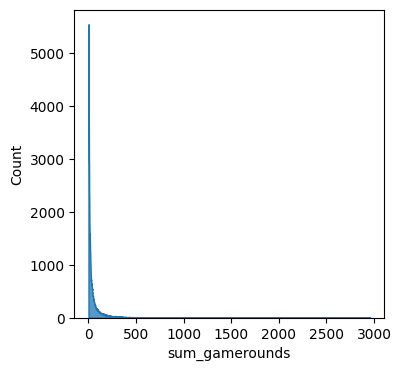

In [20]:
fig, ax = plt.subplots(figsize=(4,4))
sns.histplot(df.sum_gamerounds,stat='count',binwidth=1,multiple="dodge",element ="poly")

In [21]:
# Допущение однородности дисперсии
# H0: дисперсия однородна
pvalue = levene(df_gate_30,df_gate_40)
print(f'P-Value = {pvalue[1]}')
print('Однородность дисперсии между вдумя выборками {}установлена\n'.format( {True: 'не ',
False: ''}[pvalue[1] < alpha]));

P-Value = 0.7840494387892463
Однородность дисперсии между вдумя выборками установлена



Так как распределение не нормальное, а дисперсии однородны, то для определения наличия статистической взаимосвязи между двумя независимыми выборками будем использовать непараметрический критерий Манна-Уитни с помощью функции mannwhitneyu из библиотеки scipy.stats:

In [22]:
# H0: Статистическая разница между вдумя выборками не существует
mw = stats.mannwhitneyu(x=df_gate_30, y = df_gate_40)
print(f'P-Value = {mw[1]}')
print('Статистическая разница между вдумя выборками {}установлена\n'.format( {True: 'не ',
False: ''}[mw[1] > alpha]));

P-Value = 0.05089155279145376
Статистическая разница между вдумя выборками не установлена



Так как p-value >0.05 то мы приманием нулевую гипотезу об отсутствии статистической разницы между значениями двух выборок (т.е. между gate_30 и gate_40).

## Применение бутстрапа, определение мощности теста и уровня значимости альфа.

In [23]:
from tqdm import tqdm
from statsmodels.stats.power import tt_ind_solve_power, zt_ind_solve_power
from statsmodels.stats.meta_analysis import effectsize_smd
from scipy.stats import norm, bernoulli
from statsmodels.stats import proportion

In [24]:
# функция для рассчета статистики
def con_funk(A, B, n=1000):
  size = A.shape[0]
  Ma = A.mean()
  Mb = B.mean()
  SDa = A.std()
  SDb = B.std()

  # bootstrap
  bs = []
  for _ in tqdm(range(n)):
    Ab = A.sample(n=size, replace=True).values
    Bb = B.sample(n=size, replace=True).values
    bs.append(np.mean(Ab - Bb))
  left, right = np.percentile(bs, [2.5, 97.5])
  if left < 0 < right:
    print(f'\nДоверительный интервал: [{left:.3f}, {right:.3f}]\n'
          f'Распределение не имеет значения\n')
  else:
    print(f'\nДоверительный интервал: [{left:.3f}, {right:.3f}]\n'
          f'Распределение имеет значения\n')

  # power t-test
  effect_size, _ = effectsize_smd(mean1=Mb, sd1=SDb, nobs1=size,
                               mean2=Ma, sd2=SDa, nobs2=size)
  power = tt_ind_solve_power(effect_size=effect_size,
                             nobs1=size,
                             alpha=.05,
                             power=None,
                             ratio=1,
                             alternative='two-sided')
  if power < .8:
    print(f'{power = :.3f}\n'
          f'Уровень доверия низкий\n')
  else:
    print(f'{power = :.3f}\n'
          f'Уровеню доверия хороший\n')

  # alpha
  md, std = np.mean(bs), np.std(bs)
  alpha = 2 * (1 - norm.cdf(np.abs(md / std)))
  if alpha < .05:
    print(f'{alpha = :.3f}\n'
          f'Хорошее значение альфа\n')
  else:
    print(f'{alpha = :.3f}\n'
          f'Плохое значение альфа\n')

In [25]:
con_funk(df_gate_30, df_gate_40)

100%|██████████| 1000/1000 [00:07<00:00, 129.13it/s]



Доверительный интервал: [-1.315, 1.370]
Распределение не имеет значения

power = 0.050
Уровень доверия низкий

alpha = 0.956
Плохое значение альфа



# Выводы. Рекомендации.

Так как в результате проведенного эксперимента между двумя группами  отсутствует статистически значимая разница, я бы не рекомендовал применять на практике тестируемое изменение и провести тест повторно, перепроверив корректность его выполнения.